In [1]:
function prefix_serial!(y, ⋅)
    for i=2:length(y)
        y[i] = y[i-1] ⋅ y[i]
    end
    y
end

prefix_serial! (generic function with 1 method)

In [2]:
prefix_serial!([1:8],*)

8-element Array{Int64,1}:
     1
     2
     6
    24
   120
   720
  5040
 40320

In [3]:
function prefix8!(y, ⋅)
    length(y)==8 || error("length 8 only")
    for i in [2,4,6,8]; y[i] = y[i-1] ⋅ y[i]; end
    for i in [  4,  8]; y[i] = y[i-2] ⋅ y[i]; end
    for i in [      8]; y[i] = y[i-4] ⋅ y[i]; end
    for i in [    6  ]; y[i] = y[i-2] ⋅ y[i]; end
    for i in [ 3,5,7 ]; y[i] = y[i-1] ⋅ y[i]; end
    y
end

prefix8! (generic function with 1 method)

In [4]:
prefix8!([1:8],*)

8-element Array{Int64,1}:
     1
     2
     6
    24
   120
   720
  5040
 40320

In [5]:
import Base: getindex, setindex!, length

type DummyArray
    length      :: Int
    fromstack   :: Vector
    history     :: Vector
               
    DummyArray(length)=new(length,{},{})
end

length(D::DummyArray)=D.length

# A Read operation pushes the fromindex onto thefromstack
function getindex(D::DummyArray, fromindex)
  push!(D.fromstack, fromindex)
  nothing   
end

# A Write operation pushes  (( from1, from2) , to ) to the history
function setindex!(D::DummyArray, x, toindex)
    push!(D.history, (D.fromstack, {toindex}))
    D.fromstack = {}  # pop the fromstack
end

⋅(a::Nothing,b::Nothing)=nothing

dot (generic function with 13 methods)

In [6]:
using Compose, Gadfly, Interact

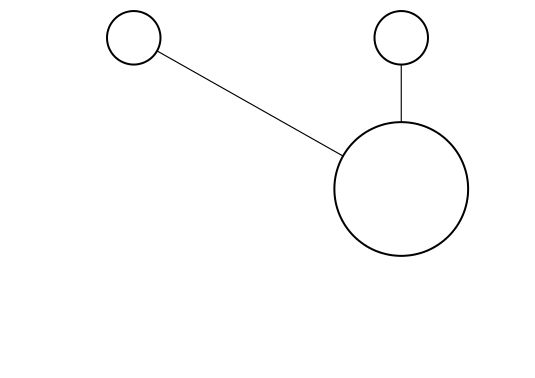

In [7]:
type gate
    ins :: Vector
    outs:: Vector
end

import Gadfly.render

function render(G::gate, x₁, y₁, y₀; rᵢ=0.1, rₒ=0.25)
    ipoints = [(i, y₀+rᵢ) for i in G.ins]
    opoints = [(i, y₀+0.5) for i in G.outs]
    igates  = [circle(i..., rᵢ) for i in ipoints]
    ogates  = [circle(i..., rₒ) for i in opoints]
    lines = [line([i, j]) for i in ipoints, j in opoints]
    compose(context(units=UnitBox(0.5,0,x₁,y₁+1)),
        compose(context(), stroke("black"), fill("white"),
            igates..., ogates...),
        compose(context(), linewidth(0.3mm), stroke("black"),
            lines...))
end

A=gate({1,2},{2})
render(A,2,0,0)

In [11]:
function render(A::DummyArray)
    #Scan to find maximum depth
    olast = depth = 0
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        olast = maximum(y[2])
    end
    maxdepth = depth
    
    olast = depth = 0
    C = {}
    for y in A.history
        (any(y[1] .≤ olast)) && (depth += 1)
        push!(C, render(gate(y...), A.length, maxdepth, depth))
        olast = maximum(y[2])
    end
    
    push!(C, compose(context(units=UnitBox(0.5,0,A.length,1)),
      [line([(i,0), (i,1)]) for i=1:A.length]...,
      linewidth(0.1mm), stroke("grey")))
    compose(context(), C...)
end

render (generic function with 31 methods)

prefix!(DummyArray(8),⋅) => DummyArray(8,{},{({1,2},{2}),({3,4},{4}),({5,6},{6}),({7,8},{8}),({2,4},{4}),({6,8},{8}),({4,8},{8}),({4,6},{6}),({2,3},{3}),({4,5},{5}),({6,7},{7})})


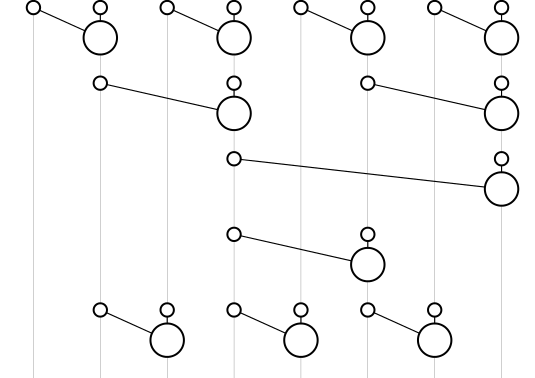

In [9]:
function prefix!(y, +)
    l=length(y)
    k=iceil(log2(l))
    @inbounds for j=1:k, i=2^j:2^j:min(l, 2^k)              #"reduce"
        y[i] = y[i-2^(j-1)] + y[i]
    end
    @inbounds for j=(k-1):-1:1, i=3*2^(j-1):2^j:min(l, 2^k) #"broadcast"
        y[i] = y[i-2^(j-1)] + y[i]
    end
    y
end
@show prefix!(DummyArray(8),⋅)
render(prefix!(DummyArray(8),⋅))

prefix_serial!(DummyArray(8),⋅) => DummyArray(8,{},{({1,2},{2}),({2,3},{3}),({3,4},{4}),({4,5},{5}),({5,6},{6}),({6,7},{7}),({7,8},{8})})


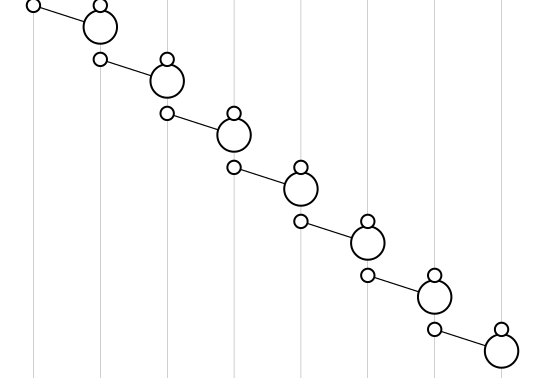

In [12]:
@show prefix_serial!(DummyArray(8),⋅)
render(prefix_serial!(DummyArray(8),⋅))

Slider{Int64}([Input{Int64}] 40,"np",40,1:80)

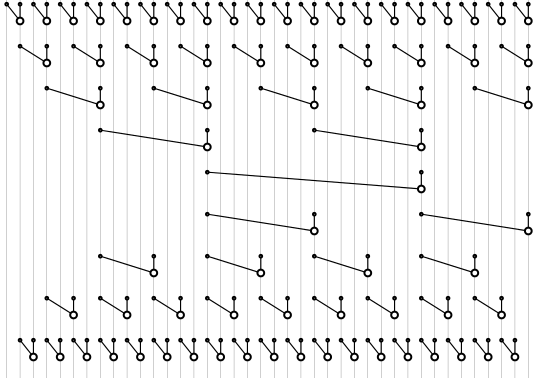

In [13]:
@manipulate for np=1:80
    render(prefix!(DummyArray(np),⋅))
end

## Parallel Prefix Speedup Curve: Matrix Multiply

<img src="scaling.png" width=500
>
